# RFM Anlysis
- Recency, Frequency, Monetary Value

* `T` - time since the first purchase (customer age) 
* `recency` - time since the last purchase
* `frequency` - total number of purchases
* `monetary_value` - total of all past purchases

## Import Libraries

In [4]:
import zipfile
import os

import numpy as np
import pandas as pd
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [5]:
data_raw = pd.read_excel(
    '../dataset/Online Retail.xlsx', 
    sheet_name='Online Retail'
)
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Preprocessing

### InvoiceNo starts with "C"

In [6]:
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")].copy()
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']
merged_data = pd.merge(
    data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
    on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
    how='left', 
    indicator=True
)

data_filtered = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]
data_filtered = data_filtered.drop(columns=['_merge'])

### Calculating total sales

In [6]:
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_filtered[features].copy()
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

### Remove CustomerID

In [6]:
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


## RFM(Recency-Frequency-Monetary) Metrics

In [7]:
def _find_first_transactions(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str,
    datetime_format: Optional[str] = None,
    time_unit: str = "D"
) -> pd.DataFrame:
    select_columns = [customer_id_col, datetime_col, monetary_value_col]

    transactions = transactions[select_columns].sort_values(select_columns).copy()

    # convert date column into a DateTimeIndex for time-wise grouping and truncating
    transactions[datetime_col] = pd.to_datetime(
        transactions[datetime_col], 
        format=datetime_format
    )
    transactions = (
        transactions.set_index(datetime_col).to_period(time_unit).to_timestamp()
    )
    transactions = transactions.reset_index()

    period_groupby = transactions.groupby(
        [datetime_col, customer_id_col], 
        sort=False, 
        as_index=False
    )

    period_transactions = period_groupby.sum()

    # create a new column for flagging first transactions
    period_transactions = period_transactions.copy()
    period_transactions.loc[:, "first"] = False
    # find all first transactions and store as an index
    first_transactions = (
        period_transactions.groupby(customer_id_col, sort=True, as_index=False)
        .head(1)
        .index
    )
    # flag first transactions as True
    period_transactions.loc[first_transactions, "first"] = True
    select_columns.append("first")
    # reset datetime_col to period
    period_transactions.loc[:, datetime_col] = period_transactions[
        datetime_col
    ].dt.to_period(time_unit)

    return period_transactions[select_columns] 

def rfm_summary(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str,
    datetime_format: Optional[str] = None,
    time_unit: str = "D",
    include_first_transaction: Optional[bool] = False,
) -> pd.DataFrame:

    observation_period_end_ts = (
            pd.to_datetime(transactions[datetime_col].max(), format=datetime_format)
            .to_period(time_unit)
            .to_timestamp()
    )

    # label repeated transactions
    repeated_transactions = _find_first_transactions(  # type: ignore
        transactions,
        customer_id_col,
        datetime_col,
        monetary_value_col,
        datetime_format,
        time_unit,
    )
    # reset datetime_col to timestamp
    repeated_transactions[datetime_col] = repeated_transactions[
        datetime_col
    ].dt.to_timestamp()

    # count all orders by customer
    customers = repeated_transactions.groupby(customer_id_col, sort=False)[
        datetime_col
    ].agg(["min", "max", "count"])

    if not include_first_transaction:
        # subtract 1 from count, as we ignore their first order.
        customers["frequency"] = customers["count"] - 1
    else:
        customers["frequency"] = customers["count"]

    customers["T"] = (
        (observation_period_end_ts - customers["min"])
        / np.timedelta64(1, time_unit)
    )
    customers["recency"] = (
        (pd.to_datetime(customers["max"]) - pd.to_datetime(customers["min"]))  # type: ignore
        / np.timedelta64(1, time_unit)
    )

    summary_columns = ["frequency", "recency", "T"]

    if not include_first_transaction:
        # create an index of all the first purchases
        first_purchases = repeated_transactions[
            repeated_transactions["first"]
        ].index
        # by setting the monetary_value cells of all the first purchases to NaN,
        # those values will be excluded from the mean value calculation
        repeated_transactions.loc[first_purchases, monetary_value_col] = np.nan
    customers["monetary_value"] = (
        repeated_transactions.groupby(customer_id_col)[monetary_value_col]
        .mean()
        .fillna(0)
    )
    summary_columns.append("monetary_value")

    summary_df = customers[summary_columns].astype(float)
    summary_df = summary_df.reset_index().rename(
        columns={customer_id_col: "customer_id"}
    )

    return summary_df

In [7]:
rfm_df = rfm_summary(
    data, 'CustomerID', 'InvoiceDate', 'TotalSales', 
    include_first_transaction=True
)

/tmp/ipykernel_840782/4061738920.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<PeriodArray>
['2010-12-07', '2011-01-26', '2011-04-07', '2011-06-09', '2011-08-02',
 '2011-10-31', '2011-12-07', '2010-12-16', '2011-01-25', '2011-04-05',
 ...
 '2011-07-14', '2011-09-05', '2011-10-27', '2011-11-10', '2011-11-23',
 '2011-11-30', '2011-12-06', '2011-05-22', '2011-10-12', '2011-10-28']
Length: 16587, dtype: period[D]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  period_transactions.loc[:, datetime_col] = period_transactions[


## Visualize RFM

### Revenue by Recency-Frequency

<Axes: xlabel='frequency', ylabel='recency'>

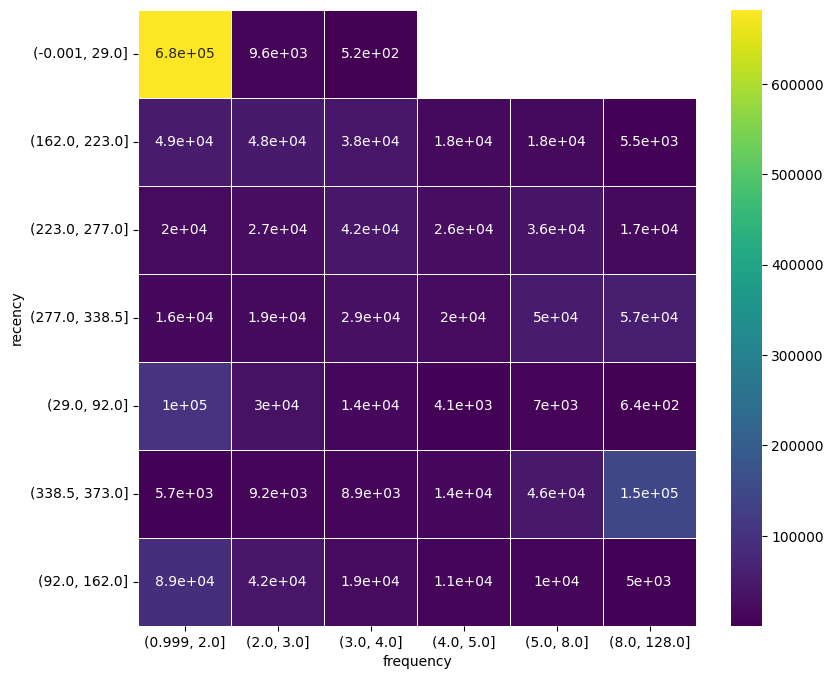

In [8]:

rfm_q = rfm_df[['customer_id', 'recency', 'frequency', 'monetary_value']].copy()
rfm_q['recency'] = pd.qcut(
    rfm_df['recency'], 
    10, duplicates='drop'
).astype('str')
rfm_q['frequency'] = pd.qcut(
    rfm_df['frequency'], 
    10, duplicates='drop'
).astype('str')

rfm_value_cohorts = rfm_q.groupby(
    ['recency', 'frequency']).sum('monetary_value').reset_index()

rfm_value_cohorts_p = rfm_value_cohorts.pivot(
    index='recency', 
    columns='frequency', 
    values='monetary_value'
)
_, ax = plt.subplots(1, 1, figsize=(9, 8))
sns.heatmap(
    rfm_value_cohorts_p, 
    annot=True, 
    linewidth=.5, 
    cmap="viridis", 
    ax=ax
)

### Differences in RFM metrics by country

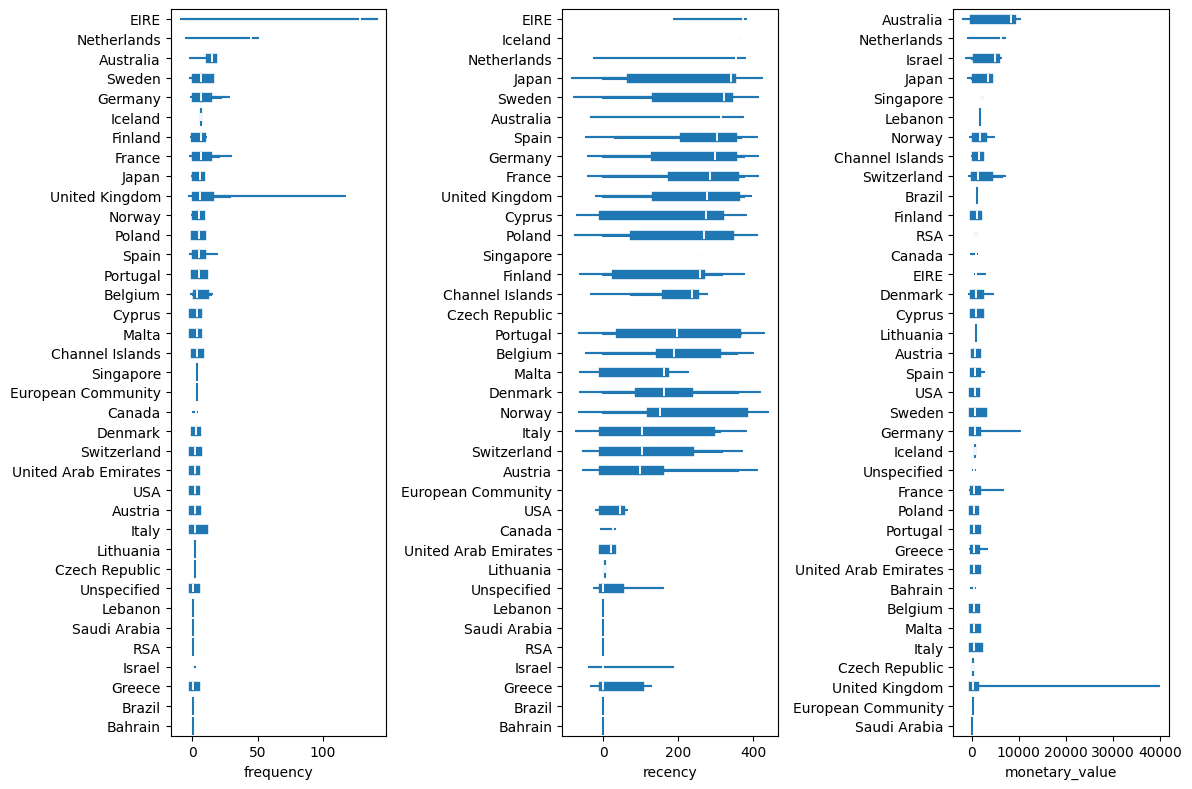

In [9]:
df = pd.merge(
    rfm_df, 
    data[['CustomerID', 'Country']], 
    how='inner', 
    left_on='customer_id', 
    right_on='CustomerID'
)
_, ax = plt.subplots(1, 3, figsize=(3*4, 8))
grouping_dim = 'Country'
for i, metric in enumerate(['frequency', 'recency', 'monetary_value']):
    my_order = df.groupby(by=[grouping_dim])[metric].median().sort_values().iloc[::-1].index
    sns.violinplot(
        data=df, 
        x=metric, 
        y=grouping_dim, 
        orient='y', 
        inner='box', 
        order=my_order, 
        fill=False, 
        ax=ax[i]
    )
    ax[i].set_ylabel(None)
plt.tight_layout()

In [10]:
df.head()

,customer_id,frequency,recency,T,monetary_value,CustomerID,Country
0,12347,7.0,365.0,367.0,615.714286,12347,Iceland
1,12347,7.0,365.0,367.0,615.714286,12347,Iceland
2,12347,7.0,365.0,367.0,615.714286,12347,Iceland
3,12347,7.0,365.0,367.0,615.714286,12347,Iceland
4,12347,7.0,365.0,367.0,615.714286,12347,Iceland
